### Group C
- Campos, Joshua
- Halili, Gesara
- Nwuzor, Chisom
- Tran, Quynh

# Data Science Project 2020

In this project, we will be tackling a supervised classification problem using the data from the Kaggle competition "[Two Sigma Connect: Rental Listing Inquiries](https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries)". Our task will be to classify rental listing inquiries, and predict how much interest they will receive according to three categories: Low, Medium and High. 

For this project, we will be using three different models, and comparing their performance to find the best one for this specific task. The models will be:
- Regularized Linear Models
- Trees
- Random Forests
- Neural Networks

Our classification problem will be composed of various sections: 
- Preparation & Exploratory Data Analysis
- Data Preprocessing & Feature Engineering
- Model Performance & Hyper-Parameter Tuning
- Prediction Explanation & Story Telling

## Preparation & Exploratory Data Analysis

### Importing the libraries

The first thing we have to do is to import all the libraries that we will be using for our project, which include the typical libraries for data science, such as Numpy, Pandas, Matplotlib, and Scikit-Learn, among others.

In [1]:
! pip install keras

In [15]:
import json
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string 

from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Dropout

from pylab import rcParams
from re import search 

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, RepeatedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, LabelEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import ElasticNet

import functions

### Reading the file

Here we read the data, which is stored as a JSON file. We will be only using the training data for the whole project, which we will split into training and testing sets respectively. This is done to decrease the processing power and time required for the model training and the hyper-parameter tuning.

In [3]:
with open('data/train.json') as f:
    data = json.load(f)

df = pd.DataFrame(data)

### Exploratory Data Analysis

Before continuing, we must get a grasp of what the data looks like. For this, we print the head of the data, as well as some statistics and information about the variables. Besides this, we also take a look at the unique number of values for the display addresses, the manager ids, and the features. 

Finally, we encode the target variable from text to numerical values, ranging from 0 to 2, and plot the counts for each class to get an idea of how balanced the dataset is.

<class 'pandas.core.frame.DataFrame'>
Index: 49352 entries, 4 to 124009
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        49352 non-null  float64
 1   bedrooms         49352 non-null  int64  
 2   building_id      49352 non-null  object 
 3   created          49352 non-null  object 
 4   description      49352 non-null  object 
 5   display_address  49352 non-null  object 
 6   features         49352 non-null  object 
 7   latitude         49352 non-null  float64
 8   listing_id       49352 non-null  int64  
 9   longitude        49352 non-null  float64
 10  manager_id       49352 non-null  object 
 11  photos           49352 non-null  object 
 12  price            49352 non-null  int64  
 13  street_address   49352 non-null  object 
 14  interest_level   49352 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB

Num. of Unique Display Addresses: 8826
Num. of Uni

/Users/quynhtran/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


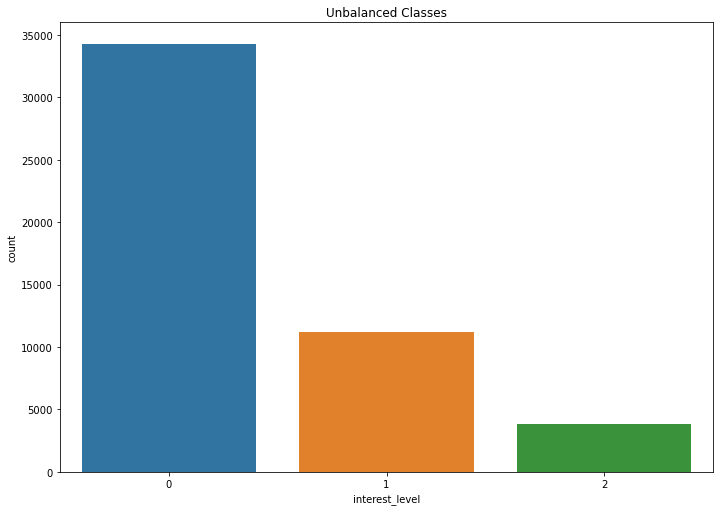

In [4]:
df_head = df.head()
df_describe = df.describe()
df_info = df.info()

print('\nNum. of Unique Display Addresses: {}'.format(df['display_address'].nunique()))
print('Num. of Unique Manager IDs: {}'.format(df['manager_id'].nunique()))

all_unique_features = set()    
df['features'].apply(lambda x: functions.add_unique_elements(x, all_unique_features))
print('Num. of Unique Features: {}'.format(len(all_unique_features)))

num_vars = ['bathrooms','bedrooms','latitude','longitude','price']
cat_vars = ['building_id','manager_id','display_address','street_address']
text_vars = ['description','features']

rcParams['figure.figsize'] = 11.7,8.27
df['interest_level'] = df['interest_level'].apply(lambda x: 0 if x=='low' else 1 if x=='medium' else 2)
# Check homogeneity of target values
sns.countplot('interest_level', data=df)
plt.title('Unbalanced Classes')
plt.show()

### Feature Engineering

#### Categorical Variables

In [5]:
addresses = ['display_address', 'street_address']

for address in addresses:
    print(address)
    ''' delete rows that contain descriptions instead of actual addresses '''
    address_delete = [] 
    for i in range(len(df)):
        address_val = df[address][i]
        if search('!' or '*', address_val):
            address_delete.append(i)

    df = df.drop(df.index[address_delete])
    print("Num. of deleted addresses: {}".format(
        len(address_delete)))
    
    
    ''' Data Cleaning '''
    address_column = df[address]
    address_column_transformed = ( address_column
                                           .apply(str.upper)
                                           .apply(lambda x: x.replace('WEST','W'))
                                           .apply(lambda x: x.replace('EAST','E'))
                                           .apply(lambda x: x.replace('STREET','ST'))
                                           .apply(lambda x: x.replace('AVENUE','AVE'))
                                           .apply(lambda x: x.replace('BOULEVARD','BLVD'))
                                           .apply(lambda x: x.replace('.',''))
                                           .apply(lambda x: x.replace(',',''))
                                           .apply(lambda x: x.replace('&',''))
                                           .apply(lambda x: x.replace('(',''))
                                           .apply(lambda x: x.replace(')',''))
                                           .apply(lambda x: x.strip())
                                           #.apply(lambda x: re.sub('(?<=\d)[A-Z]{2}', '', x))
                                           .apply(lambda x: re.sub('[^A-Za-z0-9]+ ', '', x)) #remove all special characters and punctuaction
                                           .apply(lambda x: x.replace('FIRST','1'))
                                           .apply(lambda x: x.replace('SECOND','2'))
                                           .apply(lambda x: x.replace('THIRD','3'))
                                           .apply(lambda x: x.replace('FOURTH','4'))
                                           .apply(lambda x: x.replace('FIFTH','5'))
                                           .apply(lambda x: x.replace('SIXTH','6'))
                                           .apply(lambda x: x.replace('SEVENTH','7'))
                                           .apply(lambda x: x.replace('EIGHTH','8'))
                                           .apply(lambda x: x.replace('EIGTH','8'))
                                           .apply(lambda x: x.replace('NINTH','9'))
                                           .apply(lambda x: x.replace('TENTH','10'))
                                           .apply(lambda x: x.replace('ELEVENTH','11'))
                                         )

    print("Num. of Unique Addresses after Transformation: {}".format(
        address_column_transformed.nunique()))

    df[address] = address_column_transformed 

#Count features
display=df["display_address"].value_counts()
manager_id=df["manager_id"].value_counts()
building_id=df["building_id"].value_counts()
street=df["street_address"].value_counts()

df["display_count"]=df["display_address"].apply(lambda x:display[x])
df["manager_count"]=df["manager_id"].apply(lambda x:manager_id[x])  
df["building_count"]=df["building_id"].apply(lambda x:building_id[x])
df["street_count"]=df["street_address"].apply(lambda x:street[x])

#Numeric-categorical interactions (price and building)
price_by_building = df.groupby('building_id')['price'].agg([np.min,np.max,np.mean]).reset_index()
price_by_building.columns = ['building_id','min_price_by_building',
                            'max_price_by_building','mean_price_by_building']
df = pd.merge(df,price_by_building, how='left',on='building_id')
df = df.drop(df.index[address_delete])

OE = OrdinalEncoder()
for cat_var in cat_vars:
    print ("Ordinal Encoding %s" % (cat_var))
    df[cat_var]=OE.fit_transform(df[[cat_var]])

display_address
Num. of deleted addresses: 221
Num. of Unique Addresses after Transformation: 6006
street_address
Num. of deleted addresses: 1
Num. of Unique Addresses after Transformation: 11243
Ordinal Encoding building_id
Ordinal Encoding manager_id
Ordinal Encoding display_address
Ordinal Encoding street_address


#### Text Variables

In [6]:
'''
Count number of special characters in description:
Studies have shown that titles with excessive all caps and special characters give renters the impression 
that the listing is fraudulent – i.e. BEAUTIFUL***APARTMENT***CHELSEA.
'''

df['num_of_#']=df.description.apply(lambda x:x.count('#'))
df['num_of_!']=df.description.apply(lambda x:x.count('!'))
df['num_of_$']=df.description.apply(lambda x:x.count('$'))
df['num_of_*']=df.description.apply(lambda x:x.count('*'))
df['num_of_>']=df.description.apply(lambda x:x.count('>'))

#Derive new features (check for phone and email) out of description 
df['has_phone'] = df['description'].apply(lambda x:re.sub('['+string.punctuation+']', '', x).split())\
        .apply(lambda x: [s for s in x if s.isdigit()])\
        .apply(lambda x: len([s for s in x if len(str(s))==10]))\
        .apply(lambda x: 1 if x>0 else 0)

print('Has phone: ' + str(np.round(len(np.where(df['has_phone'] == 1)[0]) / len(df), 2)) + '%')
print('Has no phone: '+ str(np.round(len(np.where(df['has_phone'] == 0)[0]) / len(df), 2)) + '%')

df['has_email'] = df['description'].apply(lambda x: 1 if '@renthop.com' in x else 0)
print('Has email: '+ str(np.round(len(np.where(df['has_email'] == 1)[0]) / len(df), 2))+ '%')
print('Has no email: '+ str(np.round(len(np.where(df['has_email'] == 0)[0]) / len(df), 2))+ '%')

# Count length, num of words and features of description of features 
display_address_column = df['description']
df['description'] = [functions.text_cleaner(x) for x in display_address_column]

df['length_description'] = df['description'].apply(lambda x: len(x))
df['num_words_description'] = df['description'].apply(lambda x: len(x.split(" ")))

df['num_features'] = df['features'].apply(len)

#Extract tokens of features and OHE 
v = CountVectorizer(stop_words='english', max_features=50)
x = v.fit_transform(df['features']\
                                     .apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x])))

df1 = pd.DataFrame(x.toarray(), columns=v.get_feature_names())
df.drop('features', axis=1, inplace=True)
df = df.join(df1.set_index(df.index))

tokens_features = v.get_feature_names()
print(tokens_features)

Has phone: 0.3%
Has no phone: 0.7%
Has email: 0.35%
Has no email: 0.65%
['balcony', 'cats_allowed', 'common_outdoor_space', 'deck', 'dining_room', 'dishwasher', 'dogs_allowed', 'doorman', 'elevator', 'exclusive', 'fireplace', 'fitness_center', 'furnished', 'garage', 'garden', 'green_building', 'hardwood', 'hardwood_floors', 'high_ceilings', 'high_speed_internet', 'laundry', 'laundry_in_building', 'laundry_in_unit', 'laundry_room', 'level', 'live', 'live_in_super', 'loft', 'lowrise', 'multi', 'new_construction', 'no_fee', 'outdoor_space', 'parking_space', 'patio', 'pool', 'pre', 'prewar', 'private_outdoor_space', 'publicoutdoor', 'reduced_fee', 'renovated', 'roof', 'roof_deck', 'simplex', 'site_laundry', 'swimming_pool', 'terrace', 'war', 'wheelchair_access']


#### Date Variables

In [7]:
df['created'] = pd.to_datetime(df['created'])
df['created_year'] = df['created'].dt.year
df['created_month'] = df['created'].dt.month
df['created_day_of_month'] = df['created'].dt.day
df['created_day_of_week'] = df['created'].dt.dayofweek
df['created_hour'] = df['created'].dt.hour

#### Image Variables

In [8]:
df['num_photos'] = df['photos'].apply(len)
df['photos_per_bedroom'] = df[['num_photos','bedrooms']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)
df['photos_per_bathroom'] = df[['num_photos','bathrooms']].apply(lambda x: x[0]/x[1] if x[1]!=0 else 0, axis=1)

#### Numerical Variables

In [9]:
df['total_rooms'] = df['bathrooms'] + df['bedrooms']
df['price_per_room'] = df[['price','total_rooms']].apply(lambda x: x[0]/x[1] if x[1] != 0 else 0, axis=1)
df['price_per_bedroom'] = df[['price','bedrooms']].apply(lambda x: x[0]/x[1] if x[1] != 0 else 0, axis=1)
df['price_per_bathroom'] = df[['price','bathrooms']].apply(lambda x: x[0]/x[1] if x[1] != 0 else 0, axis=1)

df['price_per_word_description'] = df[['price','num_words_description']].apply(lambda x: x[0]/x[1] if x[1] != 0 else 0, axis=1)
df['price_per_length_description'] = df[['price','length_description']].apply(lambda x: x[0]/x[1] if x[1] != 0 else 0, axis=1)
df['price_per_feature'] = df[['price','num_features']].apply(lambda x: x[0]/x[1] if x[1] != 0 else 0, axis=1)
df['price_per_photo'] = df[['price','num_photos']].apply(lambda x: x[0]/x[1] if x[1] != 0 else 0, axis=1)

central_park_coordinates = (40.7799963,-73.970621)
df['distance_to_central_park'] = df[['latitude','longitude']].apply(
        lambda x: functions.calculate_distance_between_coordinates(central_park_coordinates,(x[0],x[1])), axis=1)

wall_street_coordinates = (40.7059692,-74.0099558)
df['distance_to_wall_street'] = df[['latitude','longitude']].apply(
        lambda x: functions.calculate_distance_between_coordinates(wall_street_coordinates,(x[0],x[1])), axis=1)

times_square_coordinates = (40.7567473,-73.9888876)
df['distance_to_times_square'] = df[['latitude','longitude']].apply(
        lambda x: functions.calculate_distance_between_coordinates(times_square_coordinates,(x[0],x[1])), axis=1)

### Correlation of Features and Target

interest_level           1.000000
building_count           0.199969
created_hour             0.165674
max_price_by_building    0.133916
no_fee                   0.132838
                           ...   
longitude                0.004737
swimming_pool            0.003586
multi                    0.001533
level                    0.001533
created_year                  NaN
Name: interest_level, Length: 92, dtype: float64


<AxesSubplot:>

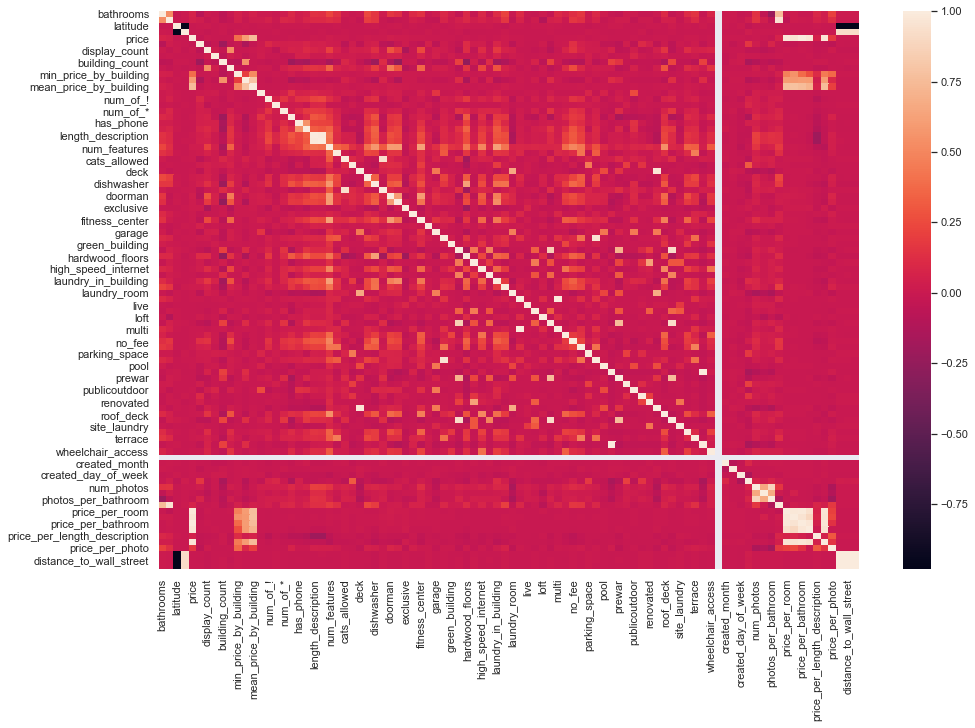

In [10]:
""" Object columns dropped"""
df = df.drop(['building_id', 'listing_id', 'description', 'created', 'display_address', 'manager_id', 
              'photos', 'street_address'], axis=1) 

# Convert target values into ordinal values 

df_corr = df.corr()
df_corr_abs = np.abs(df_corr['interest_level'])

df_corr_abs_sort = df_corr_abs.sort_values(ascending = False)
print(df_corr_abs_sort)

sns.set(rc={'figure.figsize':(15.7,10.27)})
sns.heatmap(df.corr())

### Data Normalization

In [11]:
df_copy = df.drop("interest_level", axis=1)
scaler = preprocessing.MinMaxScaler()
names = df_copy.columns
d = scaler.fit_transform(df_copy)
scaled_df = pd.DataFrame(d, columns=names)
scaled_df.head()
scaled_df= scaled_df.join(df[['interest_level']].set_index(scaled_df.index))
scaled_df

,bathrooms,bedrooms,latitude,longitude,price,display_count,manager_count,building_count,street_count,min_price_by_building,...,price_per_bedroom,price_per_bathroom,price_per_word_description,price_per_length_description,price_per_feature,price_per_photo,distance_to_central_park,distance_to_wall_street,distance_to_times_square,interest_level
0,0.10,0.125,0.907033,0.374708,0.000525,0.006608,0.043908,0.000489,0.018182,0.002050,...,0.001069,0.000535,0.000009,0.002233,0.000382,0.001308,0.000805,0.000665,0.000663,1
1,0.10,0.250,0.907935,0.374553,0.000837,0.013216,0.009889,0.006112,0.027273,0.002484,...,0.000846,0.000846,0.000006,0.001874,0.000705,0.004143,0.000303,0.000698,0.000188,0
2,0.10,0.250,0.908073,0.374635,0.000769,0.323789,0.036392,0.008557,0.231818,0.002006,...,0.000778,0.000778,0.000007,0.001866,0.000649,0.003811,0.000246,0.000829,0.000292,1
3,0.15,0.375,0.907115,0.374804,0.000659,0.088106,0.035206,0.000244,0.009091,0.002137,...,0.000445,0.000445,0.000007,0.002198,0.000000,0.003925,0.000807,0.000804,0.000723,1
4,0.10,0.000,0.907770,0.374536,0.000613,0.975771,0.021361,0.010391,0.231818,0.002006,...,0.000000,0.000622,0.000017,0.003862,0.000778,0.004571,0.000392,0.000616,0.000210,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49124,0.10,0.375,0.909985,0.374829,0.000614,0.026432,0.003560,0.000489,0.018182,0.002397,...,0.000416,0.000624,0.000005,0.001322,0.001039,0.003664,0.000797,0.001826,0.001159,0
49125,0.10,0.250,0.909461,0.374675,0.000524,0.973568,0.005142,0.015159,0.786364,0.001397,...,0.000533,0.000533,0.000007,0.001845,0.000381,0.003134,0.000458,0.001482,0.000812,1
49126,0.10,0.125,0.904040,0.374695,0.000402,0.002203,0.043908,0.000611,0.022727,0.001310,...,0.000824,0.000412,0.000006,0.001652,0.000187,0.004034,0.002379,0.001663,0.002150,1
49127,0.10,0.250,0.907790,0.374304,0.000925,0.224670,0.012658,0.001345,0.054545,0.002654,...,0.000934,0.000934,0.000008,0.002091,0.000934,0.005489,0.000519,0.000469,0.000187,1


### Splitting of the Dataset

In [19]:
X = scaled_df.drop("interest_level", axis=1)
y = scaled_df["interest_level"]

X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_test, X_val, y_test, y_val = train_test_split(X_rest, y_rest, test_size = 0.5, random_state = 42)

### Feature Selection

In [20]:
sel = SelectFromModel(RandomForestClassifier())
sel.fit(X_train, y_train)


#To see which feature are important
sel.get_support()


#to get the number of important features
selected_feat= X_train.columns[(sel.get_support())]
len(selected_feat)


#to get the name of feature selected
print(selected_feat)


X_train= X_train[selected_feat]
X_test= X_test[selected_feat]


Index(['latitude', 'longitude', 'price', 'display_count', 'manager_count',
       'building_count', 'street_count', 'min_price_by_building',
       'max_price_by_building', 'mean_price_by_building', 'num_of_!',
       'num_of_>', 'length_description', 'num_words_description',
       'num_features', 'created_month', 'created_day_of_month',
       'created_day_of_week', 'created_hour', 'num_photos',
       'photos_per_bedroom', 'photos_per_bathroom', 'price_per_room',
       'price_per_bedroom', 'price_per_bathroom', 'price_per_word_description',
       'price_per_length_description', 'price_per_feature', 'price_per_photo',
       'distance_to_central_park', 'distance_to_wall_street',
       'distance_to_times_square'],
      dtype='object')


### Hyperparameter Tuning  for the Random Forest

In [ ]:
 # Number of trees in random forest
n_estimators = np.arange(start=100, stop=2001, step=10)
 #Number of features to consider at every split'''
max_features = ['auto', 'sqrt']
 #Maximum number of levels in tree'''
max_depth = np.arange(start=10, stop=111, step=5)
#max_depth.append(None)
 #Minimum number of samples required to split a node'''
min_samples_split = np.arange(start=2, stop=101)
 #Minimum number of samples required at each leaf node'''
min_samples_leaf = np.arange(start=2, stop=101)
#Method of selecting samples for training each tree'''
bootstrap = [True, False]


'''Create the random grid'''
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


'''First create the base model to tune'''

rf = RandomForestClassifier()

''' Use the random grid to search for best hyperparameters'''
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 5, verbose=2, 
                               random_state=123, n_jobs = -1)

'''Fit the random search model'''
rf_random.fit(X_train, y_train)

print('test')

best_params = rf_random.best_params_

print(best_params)

### Pruning of the Decision Tree

In [ ]:
tree = DecisionTreeClassifier(criterion = "gini", random_state = 123) 
tree = tree.fit(X_train, y_train) 
y_pred = tree.predict(X_test) 
print ("Accuracy : ", accuracy_score(y_test,y_pred)*100) 



#ploting the tree

from sklearn.tree import plot_tree
plt.figure(figsize = (15,17))
plot_tree(tree, filled = True, rounded = True, class_names = ['Low Interest', 'Medium Interest', 'High Interest'], feature_names = X.columns)[0]

#determine values for alpha
path = tree.cost_complexity_pruning_path(X_train, y_train)

#extract different values for alpha
ccp_alphas = path.ccp_alphas 
ccp_alphas = ccp_alphas[:-1]


#create an array to store the resuls of each fold during cross validation
alpha_loop_values = []

# For each candidate value alpha, we will run 5-fold cross validation
# Then we will store the mean and std of the scores(accuracy) for each call
# to cross_val_score in alpha_loop_values...

for ccp_alpha in ccp_alphas:
    tree = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    scores = cross_val_score(tree, X_train, y_train, cv=5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])
#Now we can draw a graph of the means and std of the scores
#for each candidate value for alpha
alpha_results = pd.DataFrame(alpha_loop_values, 
                             columns=['alpha', 'mean_accuracy', 'std'])

alpha_results.plot(x='alpha',
                   y='mean_accuracy',
                   yerr = 'std',
                   marker = 'o',
                  linestyle ='--')


#Printing the best alpha

column = alpha_results["mean_accuracy"]
max_index = column.idxmax()
max_index


ideal_ccp_alpha = alpha_results.iloc[max_index]['alpha']
#ideal_ccp_alpha 
#Prunning the classification tree

tree_pruned = DecisionTreeClassifier(random_state = 123,
                                    ccp_alpha=ideal_ccp_alpha)
tree_pruned = tree_pruned.fit(X_train, y_train)




y_pred = tree_pruned.predict(X_test) 
print ("Accuracy : ", accuracy_score(y_test,y_pred)*100) 

#plotting the best tree
plt.figure(figsize = (20,17))
plot_tree(tree_pruned, filled = True, rounded = True,class_names = ['Low Interest', 'Medium Interest', 'High Interest'], feature_names = X.columns)[0]

### Model Selection

In [ ]:
#Defining model parameters from the tuned parameter
model_params = {
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': best_params['n_estimators'],
            'min_samples_split': best_params['min_samples_split'],
            'min_samples_leaf': best_params['min_samples_leaf'],
            'max_features': best_params['max_features'],
            'max_depth': best_params['max_depth'],
            'bootstrap': best_params['bootstrap']
        }
    },
    
    'decision_tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'ccp_alpha': ideal_ccp_alpha
        }
    },
    
}

#Loop over both decision tree and random forest to determine the best model for the given dataset
scores = []
print(model_params.items())

trained_models = []
for model_name, mp in model_params.items():
    clf = mp['model']
    clf.set_params(**mp['params'])
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)
    scores.append({
        'model': model_name,
        'train_score': clf.score(X_train, y_train),
        'test_score': clf.score(X_test, y_test),
        'log_loss': log_loss(y_test, y_pred)
    })
    trained_models.append(clf)
    
best_model = pd.DataFrame(scores, columns= ['model','train_score','test_score', 'log_loss'])
print(best_model)

rf = trained_models[0]

### Feature Importance

In [ ]:
#MDI
MDI_importances = rf.feature_importances_
indices = np.argsort(MDI_importances)
features = X_train.columns

#MDA
MDA_test = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=123)
sorted_idx1 = MDA_test.importances_mean.argsort()
MDA_train = permutation_importance(rf, X_train, y_train, n_repeats=10, random_state=123)
sorted_idx2 = MDA_train.importances_mean.argsort()

#Plotting
plt.rcParams["figure.figsize"]=15,5
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.set_title('MDI Importances')
ax1.barh(range(len(indices)), MDI_importances[indices], color='b', align='center')
ax1.set_yticks( np.arange(len(X_train.columns)))
ax1.set_yticklabels(features[indices])
ax1.set(xlabel='Relative Importance')
ax2.boxplot(MDA_train.importances[sorted_idx2].T,
vert=False, labels=features[sorted_idx2])
tpmp=ax2.set_title("Permutation Importances (train)")
ax3.boxplot(MDA_test.importances[sorted_idx1].T,
vert=False, labels=features[sorted_idx1])
tpmp=ax3.set_title("Permutation Importances (test)")
fig.tight_layout()

#Table of results
# record times for comparison
t0 = time()
# Gini importance
gini_imp = pd.DataFrame({'Feature': X_train.columns, 'Gini Importance': rf.feature_importances_}).set_index('Feature')

t1 = time()# Permutation importance for train
perm_imp = importances(rf, X_train, y_train)

t2 = time()
res= gini_imp.merge(perm_imp, left_index=True, right_index=True).reset_index().\
        rename(columns={'Importance': 'Permutation Importance'})
res.loc[len(X_train.columns)+1] = ['runtime(s)', t1-t0, t2-t1]

res

### Neural Network 

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 256)               8448      
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_48 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_49 (Dense)             (None, 3)                 99        
Total params: 27,075
Trainable params: 27,075
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
4299/4299 [==============================] - 6s 1ms/step - loss: 0.7970 - accuracy: 0.6865 - val_loss: 0

[]

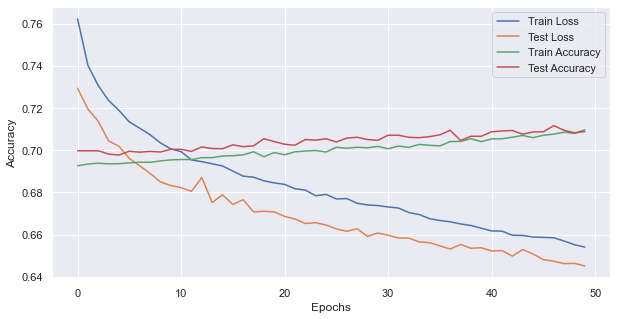

In [40]:
n_classes = len(np.unique(y))
n_features = X_train.shape[1]

ffnn = Sequential()
ffnn.add(Dense(256, activation='relu', input_shape=(n_features,)))
ffnn.add(Dropout(0.3))
ffnn.add(Dense(64, activation='relu'))
ffnn.add(Dense(32, activation='relu'))
ffnn.add(Dense(n_classes, activation='softmax'))

ffnn.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])
ffnn.summary()

trained_ffnn = ffnn.fit(X_train, y_train,
          validation_data = (X_test, y_test),
          epochs=50, 
          batch_size=8, 
          verbose=1
         )

rcParams['figure.figsize'] = 10, 5
plt.plot(ffnn.history.history['loss'], label = "Train Loss")
plt.plot(ffnn.history.history['val_loss'], label = "Test Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.plot()

rcParams['figure.figsize'] = 10, 5
plt.plot(ffnn.history.history['accuracy'], label = "Train Accuracy")
plt.plot(ffnn.history.history['val_accuracy'], label = "Test Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.plot()